## Importing Libraries & Loading Data

In [1]:
# supressing warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#importing required libraries 
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [3]:
# We'll be using Standard Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # Train-Test Split

# Just for automated feature selection using RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# We'll use stats model since it gives better statistics
import statsmodels.api as sm

# To check Multicolinearity using VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# For evaluation of model
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [4]:
#reading the dataset
df = pd.read_csv('Leads.csv')

## Data Understanding

In [5]:
df.head(8)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified
5,2058ef08-2858-443e-a01f-a9237db2f5ce,660680,API,Olark Chat,No,No,0,0.0,0,0.0,Olark Chat Conversation,NaN,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,NaN,NaN,No,No,NaN,NaN,01.High,02.Medium,17.0,15.0,No,No,Modified
6,9fae7df4-169d-489b-afe4-0f3d752542ed,660673,Landing Page Submission,Google,No,No,1,2.0,1640,2.0,Email Opened,India,Supply Chain Management,Online Search,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Low in Relevance,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,No,Modified
7,20ef72a2-fb3b-45e0-924e-551c5fa59095,660664,API,Olark Chat,No,No,0,0.0,0,0.0,Olark Chat Conversation,NaN,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,NaN,NaN,No,No,NaN,NaN,02.Medium,02.Medium,15.0,15.0,No,No,Modified


In [6]:
# Shape of the data
df.shape

(9240, 37)

In [7]:
# Lets analyse the statistical variation of the dataset (possible only for numerical attributes)
df.describe(percentiles=[0.05,.25, .5, .75, .90, .95, .99])

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
5%,582869.900000,0.000000,0.000000,0.000000,0.000000,12.000000,14.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
90%,650506.100000,1.000000,7.000000,1380.000000,5.000000,16.000000,19.000000
95%,655404.050000,1.000000,10.000000,1562.000000,6.000000,17.000000,20.000000


- We can see that in `TotalVisits`, `Page Views Per Visit`, `Total Time Spent on Website` columns, there is sharp increase in value from 95 percentile to 100 percentile. This may be due to presence of outlier.
- Other columns dont have evident outliers and we'll analyse further.

In [8]:
# Viewing the info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [9]:
df['Prospect ID'].nunique()

9240

In [10]:
df['Lead Number'].nunique()

9240

- We can see that in `Prospect ID` & `Lead Number` column, there are 9240 unique values i.e same as dataset size. It is only an identifier of viewers/users, hence stats don't matter
- This kind of information is not helpful for model building & we can drop them.

In [11]:
df['I agree to pay the amount through cheque'].value_counts()

No    9240
Name: I agree to pay the amount through cheque, dtype: int64

- Also column `I agree to pay the amount through cheque` has only one value. Low variance column is also not helpful for model building. We can drop this column.

## Cleaning Dataset

- We'll drop `Prospect ID`,`Lead Number`,`I agree to pay the amount through cheque` columns.
- We will trim lengthy column names and would modify the same to follow snakecase nomenclature.
- There are few columns with `Select` as data value - specifying the user has not selected any option. Hence we will replace these with `NaN` values.

In [12]:
# Dropping mentioned features
df.drop(['Prospect ID','Lead Number','I agree to pay the amount through cheque'], axis=1, inplace=True)
# df.head()

In [13]:
# Changing column names for snakecase nomenclature
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.columns

Index(['lead_origin', 'lead_source', 'do_not_email', 'do_not_call',
       'converted', 'totalvisits', 'total_time_spent_on_website',
       'page_views_per_visit', 'last_activity', 'country', 'specialization',
       'how_did_you_hear_about_x_education', 'what_is_your_current_occupation',
       'what_matters_most_to_you_in_choosing_a_course', 'search', 'magazine',
       'newspaper_article', 'x_education_forums', 'newspaper',
       'digital_advertisement', 'through_recommendations',
       'receive_more_updates_about_our_courses', 'tags', 'lead_quality',
       'update_me_on_supply_chain_content', 'get_updates_on_dm_content',
       'lead_profile', 'city', 'asymmetrique_activity_index',
       'asymmetrique_profile_index', 'asymmetrique_activity_score',
       'asymmetrique_profile_score', 'a_free_copy_of_mastering_the_interview',
       'last_notable_activity'],
      dtype='object')

In [14]:
# Shorten column names for better readability 
df.rename(columns={'totalvisits': 'total_visits', 'total_time_spent_on_website': 'time_on_website', 
                    'how_did_you_hear_about_x_education': 'source', 'what_is_your_current_occupation': 'occupation',
                    'what_matters_most_to_you_in_choosing_a_course' : 'course_selection_reason', 
                    'receive_more_updates_about_our_courses': 'courses_updates', 
                     'update_me_on_supply_chain_content': 'supply_chain_content_updates',
                    'get_updates_on_dm_content': 'dm_content_updates',
                    'i_agree_to_pay_the_amount_through_cheque': 'cheque_payment',
                    'a_free_copy_of_mastering_the_interview': 'mastering_interview'}, inplace = True)

df.head(3)

,lead_origin,lead_source,do_not_email,do_not_call,converted,total_visits,time_on_website,page_views_per_visit,last_activity,country,specialization,source,occupation,course_selection_reason,search,magazine,newspaper_article,x_education_forums,newspaper,digital_advertisement,through_recommendations,courses_updates,tags,lead_quality,supply_chain_content_updates,dm_content_updates,lead_profile,city,asymmetrique_activity_index,asymmetrique_profile_index,asymmetrique_activity_score,asymmetrique_profile_score,mastering_interview,last_notable_activity
0,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,Modified
1,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,Yes,Email Opened


In [15]:
# Select all columns with object datatype
df_obj = df.select_dtypes(include='object')

# Find out columns that have "Select"
s = lambda x: x.str.contains('Select', na=False)
l = df_obj.columns[df_obj.apply(s).any()].tolist()
print (l)

['specialization', 'source', 'lead_profile', 'city']


In [16]:
# select all the columns that have a "Select" entry
sel_cols = ['specialization', 'source', 'lead_profile', 'city']

# replace values
df[sel_cols] = df[sel_cols].replace('Select', np.NaN)

### Let's check Categorical Columns

In [17]:
# Getting object columns & Printing their value_counts
obj_cols = list(df.dtypes[df.dtypes==np.object].keys())
for i in obj_cols:
  print('----------', i, '----------\n', df[i].value_counts(dropna=False),
  '\n-----------------------------------------------------', sep='')

----------lead_origin----------
Landing Page Submission    4886
API                        3580
Lead Add Form               718
Lead Import                  55
Quick Add Form                1
Name: lead_origin, dtype: int64
-----------------------------------------------------
----------lead_source----------
Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
NaN                    36
bing                    6
google                  5
Click2call              4
Live Chat               2
Social Media            2
Press_Release           2
youtubechannel          1
WeLearn                 1
NC_EDM                  1
welearnblog_Home        1
testone                 1
Pay per Click Ads       1
blog                    1
Name: lead_source, dtype: int64
-----------------------------------------------------
----------do_not_email----------

- Some columns got only single value, we can drop them.
- `do_not_call`, `search`, `newspaper_article`, `x_education_forums`, `newspaper`, `digital_advertisement`, `through_recommendations` columns have 99% data in single value. Those columns are heavily skewed. We can drop them.

In [18]:
# Dropping columns with single value

drop = ['courses_updates', 'magazine', 'supply_chain_content_updates', 'dm_content_updates', 'do_not_call', 'search',
        'newspaper_article', 'x_education_forums', 'newspaper', 'digital_advertisement', 'through_recommendations']
df = df.drop(drop, axis=1)

### Cleaning `lead_source` column

- `lead_source` has duplicate value of `Google` in lower case. We can replace them with correct case.

In [19]:
df['lead_source']=df['lead_source'].replace('google', 'Google')
df['lead_source'].value_counts(dropna=False)

Google               2873
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
NaN                    36
bing                    6
Click2call              4
Live Chat               2
Social Media            2
Press_Release           2
NC_EDM                  1
youtubechannel          1
WeLearn                 1
blog                    1
welearnblog_Home        1
testone                 1
Pay per Click Ads       1
Name: lead_source, dtype: int64

### Checking for null values in the dataframe

In [20]:
# Checking for total count and percentage of null values in all columns of the dataframe.

def check_null(df):
  null_data = pd.DataFrame(df.isnull().sum().sort_values(ascending=False), columns=['Total_null'])
  null_data['Percentage'] = round(100*(null_data['Total_null']/df.shape[0]),2)
  return null_data

null_df = check_null(df)
null_df.head(10) # showing top 10 columns with high null value

,Total_null,Percentage
source,7250,78.46
lead_profile,6855,74.19
lead_quality,4767,51.59
asymmetrique_profile_score,4218,45.65
asymmetrique_activity_score,4218,45.65
asymmetrique_profile_index,4218,45.65
asymmetrique_activity_index,4218,45.65
city,3669,39.71
specialization,3380,36.58
tags,3353,36.29


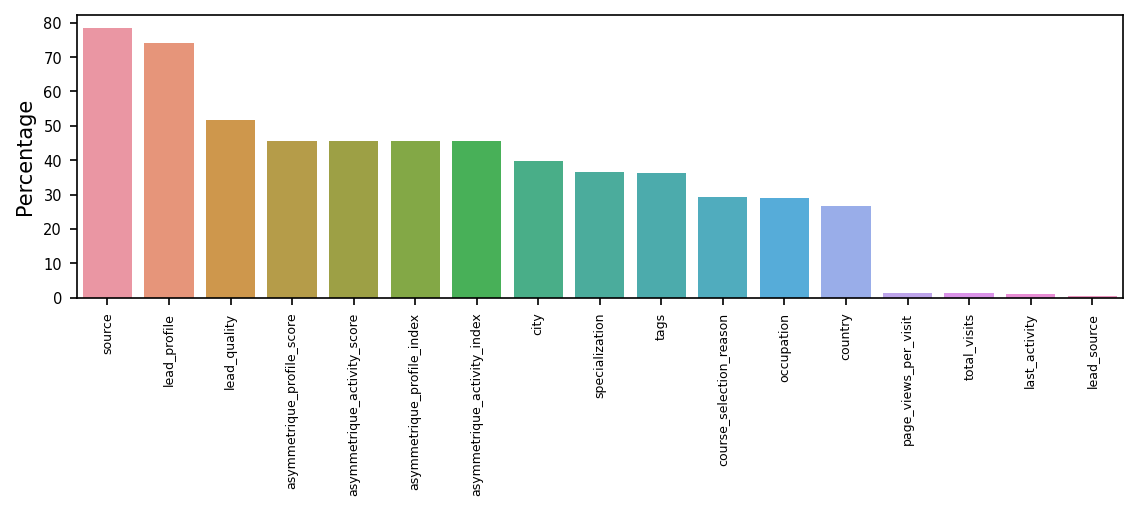

Total Columns with null data: 23


In [21]:
# Plotting columns with null data
plt.figure(figsize=[9,2.5],dpi=150)
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=7)
sns.barplot(data=null_df[null_df['Total_null']>0], y='Percentage', x=null_df[null_df['Total_null']>0].index)
plt.xticks(rotation = 90)
plt.show()

print('Total Columns with null data:',len(null_df))

**Dropping columns with null value > 30%**

In [22]:
high_null = null_df[null_df['Percentage']>30]
print('Columns with very high null data:\n', high_null.index.values)

Columns with very high null data:
 ['source' 'lead_profile' 'lead_quality' 'asymmetrique_profile_score'
 'asymmetrique_activity_score' 'asymmetrique_profile_index'
 'asymmetrique_activity_index' 'city' 'specialization' 'tags']


- Above columns have null values>30 percentage.
- It's not recommended to build with features with high null value. So let's drop these columns

In [23]:
df = df.drop(high_null.index.values, axis=1)
df.head()

,lead_origin,lead_source,do_not_email,converted,total_visits,time_on_website,page_views_per_visit,last_activity,country,occupation,course_selection_reason,mastering_interview,last_notable_activity
0,API,Olark Chat,No,0,0.0,0,0.0,Page Visited on Website,NaN,Unemployed,Better Career Prospects,No,Modified
1,API,Organic Search,No,0,5.0,674,2.5,Email Opened,India,Unemployed,Better Career Prospects,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,1,2.0,1532,2.0,Email Opened,India,Student,Better Career Prospects,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,No,0,1.0,305,1.0,Unreachable,India,Unemployed,Better Career Prospects,No,Modified
4,Landing Page Submission,Google,No,1,2.0,1428,1.0,Converted to Lead,India,Unemployed,Better Career Prospects,No,Modified


## Imputing Null values

In [24]:
null_df2 = check_null(df)
null_df2 = null_df2[null_df2['Total_null']>0]
null_df2

,Total_null,Percentage
course_selection_reason,2709,29.32
occupation,2690,29.11
country,2461,26.63
page_views_per_visit,137,1.48
total_visits,137,1.48
last_activity,103,1.11
lead_source,36,0.39


- We can replace columns with null values <2% with mode of the column.
- `Occupation` column has 29% null value. It's mode value is Unemployed. We can replace NaN with mode of column.
- `total_visits` & `page_views_per_visit` are numerical column & as we have seen previously, they got outliers. So we can impute them with the median value.
- `Course Selection Reason` has only 3 value & it's skewed towards one value. This columns doesn't give much information. We can drop this column.

In [25]:
# replacing nan value with mode for columns with <2% null value
mode_replace = ['last_activity', 'lead_source', 'occupation']
for i in mode_replace:
  df[i] = df[i].replace(np.nan, df[i].mode()[0])

In [26]:
# imputing some numeric column with outliers with median value
median_replace = ['total_visits', 'page_views_per_visit']
for i in median_replace:
  df[i] = df[i].replace(np.nan, df[i].median())

In [27]:
# Dropping Course Selection Reason Column
df = df.drop('course_selection_reason', axis=1)

## Let's check numeric columns

- There are only 4 numeric columns in the dataset.
- We have already seen that there are some outliers in `total_visits` & `page_views_per_visit` columns from initial analysis.
- `time_on_website` shows gradual increase in value. That will be handled in scaling.

In [28]:
# Print numeric columns
numeric_col = df.dtypes[(df.dtypes==np.int64) | (df.dtypes==np.float)]
print(list(numeric_col.index))

['converted', 'total_visits', 'time_on_website', 'page_views_per_visit']


In [29]:
round(df[numeric_col.index].describe(percentiles=[0.15, 0.35, 0.55, 0.75, 0.95, 0.97, 0.99, 1]), 2)

,converted,total_visits,time_on_website,page_views_per_visit
count,9240.00,9240.00,9240.00,9240.00
mean,0.39,3.44,487.70,2.36
std,0.49,4.82,548.02,2.15
min,0.00,0.00,0.00,0.00
15%,0.00,0.00,0.00,0.00
35%,0.00,2.00,98.00,1.50
50%,0.00,3.00,248.00,2.00
55%,0.00,3.00,305.00,2.00
75%,1.00,5.00,936.00,3.00
95%,1.00,10.00,1562.00,6.00


- To handle these outliers in `total_visits` & `page_views_per_visit` column, we'll cap them at 97 percentile.

In [30]:
# Removing values > 97 percentile value
df = df[(df['total_visits'] <= df['total_visits'].quantile(0.97))]
df = df[(df['page_views_per_visit'] <= df['page_views_per_visit'].quantile(0.97))]

In [31]:
round(df[numeric_col.index].describe(percentiles=[0.15, 0.35, 0.55, 0.75, 0.95, 0.97, 0.99, 1]), 2)

,converted,total_visits,time_on_website,page_views_per_visit
count,8804.00,8804.00,8804.00,8804.00
mean,0.38,2.87,477.95,2.15
std,0.49,2.45,546.08,1.73
min,0.00,0.00,0.00,0.00
15%,0.00,0.00,0.00,0.00
35%,0.00,2.00,90.00,1.50
50%,0.00,3.00,238.00,2.00
55%,0.00,3.00,295.00,2.00
75%,1.00,4.00,915.25,3.00
95%,1.00,7.00,1556.85,5.00


## Data Visualization

### Visualizing Occupation

In [32]:
# Visualizing count of Occupation based on Converted value
fig1=px.histogram(df, x='occupation', color='converted', barmode='group',hover_data=df.columns,labels={'occupation': 'Occupation'})
fig1.show()

- It seems the highest number of leads belong to `Unemployed` category. But it is also seen that `Working Professional` have higher chances of getting enrolled.

### Visualizing Country Column

In [33]:
# Bar plot of Country column

fig2=px.histogram(df, x='country', color="converted", barmode='group',hover_data=df.columns,
                  labels={'country': 'Country'})
fig2.show()

- Majority of lead is from india. UAE, USA, Singapore contribute few conversion.
- We can see that data in country column is heavily skewed. We'll drop this column.

In [34]:
# Dropping Country Column
df = df.drop('country', axis=1)

### Visualizing Lead Source Column

In [35]:
# Bar plot of Lead source columnn

fig3=px.histogram(df, x='lead_source', color="converted", barmode='group',hover_data=df.columns,
                  labels={'lead_source': 'Lead Source'})
fig3.show()

- We can see that majority of Leads come from `Google, Direct Traffic & Reference`.
- `Refrence` & `Welingak Website` have high conversion rate.
- Though from `Olark Chat` lot of people are coming, conversion rate is comparatively low. Company has to focus on conversion coming from this source.

### Visualizing Last Activity Column

In [36]:
# Bar plot of Last Activity columnn
fig4=px.histogram(df, x='last_activity', color="converted", barmode='group',hover_data=df.columns,
                  labels={'last_activity': 'Last Activity'})
fig4.show()

- `SMS Sent` has high conversion rate & highest people converted after this activity.
- `Olark Chat Conversation` doesn't lead to much conversion. Company can decrease priority from assigning resources for this business activity.
- People reacted through email gives healthy amount of conversion rate.
- We can say that company should prioritize email & sms activity.

### Visualizing Lead Origin Column

In [37]:
# Bar plot of Lead Origin columnn
fig4=px.histogram(df, x='lead_origin', color="converted", barmode='group',hover_data=df.columns,
                  labels={'lead_origin': 'Lead Origin'})
fig4.show()

- API & Landing Page Submission have count in the dataset. We can see that they give good amount of conversion.
- However `Lead Add Form`, the 3rd highest count in the dataset, gives highest conversion rate.

### Let's see Correlation between Numeric columns

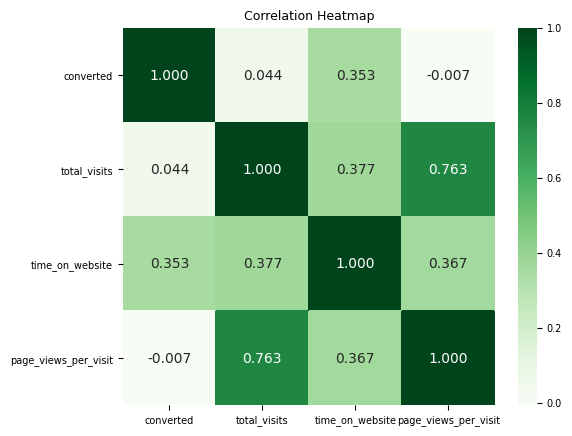

In [38]:
#Checking correlations of numeric values
plt.figure(figsize=(6,5),dpi=100)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)

sns.heatmap(df.corr(method = 'pearson'), annot=True, fmt='.3f', cmap='Greens')
plt.title('Correlation Heatmap',fontsize=9)
plt.yticks(rotation=0)
plt.show()

- `Converted` & `Page View Per Visit` shows negative correlation.
- However `Time on Website` shows good correlation with `Converted` column.

### Box plot of Numeric columns

- We have already treated outlier in numeric columns. Now let's see their boxplots & distribution

In [39]:
# Box plot of total_visits & page_views_per_visit
fig = go.Figure()
fig.add_trace(go.Box(x=df.total_visits, name="Total Visits"))
fig.add_trace(go.Box(x=df.page_views_per_visit, name="Page View per Visit"))

fig.show()

## Data Transformation

### Transforming some Yes/No column

In [40]:
# Columns with Yes No value
yes_no = ['mastering_interview', 'do_not_email']

# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# Applying the function 
df[yes_no] = df[yes_no].apply(binary_map)

### Transforming using One Hot Encoding

- We'll dummy encode remaining categorical column & drop longest column name from dummy DataFrame.
- We'll use a for loop to automate this. We'll use custom prefixes. So that we can distinguish different hot encoded columns.

In [41]:
dummy_enc = list(df.dtypes[df.dtypes==np.object].keys())
prefix = ['lead_org', 'lead_src', 'ls_act', 'occu', 'ls_not_act']

for i,j in zip(dummy_enc, prefix):
  # creating dummies 
  dummy = pd.get_dummies(df[i], prefix  = j)

  # dropping the longest column
  drop = max(df[i].value_counts().index, key = len)
  drop = j+'_'+drop
  dummy = dummy.drop(drop, 1)

  # merging with df
  df = pd.concat([df,dummy],1)

  # Dropping original Columns since we have already created dummies
  df = df.drop(i, axis=1)

## Train-test Split

In [42]:
# Setting Output variable to Coverted column & rest to input
y = df['converted']
X = df.drop('converted', axis=1)

In [43]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100, stratify=y)

In [44]:
y_train.value_counts(normalize=True)

0    0.616358
1    0.383642
Name: converted, dtype: float64

In [45]:
y_test.value_counts(normalize=True)

0    0.616578
1    0.383422
Name: converted, dtype: float64

- We can see that since we have used stratify=yes, we are getting almost similar conversion ratio in both train & test dataset.

## Scaling Features

In [46]:
# initializing a Scaler object
scaler = StandardScaler()

num_cols=X_train.select_dtypes(include=['float64', 'int64']).columns.values
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_train

,do_not_email,total_visits,time_on_website,page_views_per_visit,mastering_interview,lead_org_API,lead_org_Lead Add Form,lead_org_Lead Import,lead_org_Quick Add Form,lead_src_Click2call,lead_src_Direct Traffic,lead_src_Facebook,lead_src_Google,lead_src_Live Chat,lead_src_NC_EDM,lead_src_Olark Chat,lead_src_Organic Search,lead_src_Press_Release,lead_src_Reference,lead_src_Referral Sites,lead_src_Social Media,lead_src_WeLearn,lead_src_Welingak Website,lead_src_bing,lead_src_blog,lead_src_testone,lead_src_welearnblog_Home,lead_src_youtubechannel,ls_act_Approached upfront,ls_act_Converted to Lead,ls_act_Email Bounced,ls_act_Email Link Clicked,ls_act_Email Marked Spam,ls_act_Email Opened,ls_act_Email Received,ls_act_Form Submitted on Website,ls_act_Had a Phone Conversation,ls_act_Olark Chat Conversation,ls_act_Page Visited on Website,ls_act_Resubscribed to emails,ls_act_SMS Sent,ls_act_Unreachable,ls_act_Unsubscribed,ls_act_Visited Booth in Tradeshow,occu_Businessman,occu_Housewife,occu_Other,occu_Student,occu_Unemployed,ls_not_act_Approached upfront,ls_not_act_Email Bounced,ls_not_act_Email Link Clicked,ls_not_act_Email Marked Spam,ls_not_act_Email Opened,ls_not_act_Email Received,ls_not_act_Form Submitted on Website,ls_not_act_Had a Phone Conversation,ls_not_act_Modified,ls_not_act_Olark Chat Conversation,ls_not_act_Page Visited on Website,ls_not_act_Resubscribed to emails,ls_not_act_SMS Sent,ls_not_act_Unreachable,ls_not_act_Unsubscribed
9034,-0.291306,0.869143,1.454094,-0.275792,-0.656020,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1490,-0.291306,0.869143,1.887537,1.639555,1.524344,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2017,-0.291306,0.050860,-0.716776,-0.373572,-0.656020,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8133,-0.291306,1.278284,-0.610701,2.214734,-0.656020,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4977,3.432817,1.278284,1.035283,2.214734,-0.656020,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4932,3.432817,-0.358281,0.978588,-0.085983,-0.656020,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2571,-0.291306,-0.358281,1.957034,-0.661162,-0.656020,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4615,-0.291306,-0.358281,1.241945,-0.085983,1.524344,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3940,-0.291306,0.050860,1.048085,0.489196,-0.656020,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


## Selecting features using RFE

In [47]:
# Create a LogisticRegression object
logreg = LogisticRegression() # from sklearn library

rfe = RFE(logreg, 15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)

In [48]:
# columns RFE is selecting
rfe.support_

array([False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False,  True, False, False,
        True, False, False, False,  True, False, False, False, False,
       False,  True, False, False, False, False,  True, False, False,
       False,  True, False, False,  True, False, False, False, False,
       False,  True,  True,  True, False, False, False, False, False,
       False, False,  True, False, False, False, False,  True,  True,
       False])

In [49]:
# Getting a list of all columns & selection status by RFE
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('do_not_email', False, 15),
 ('total_visits', False, 19),
 ('time_on_website', True, 1),
 ('page_views_per_visit', False, 20),
 ('mastering_interview', False, 38),
 ('lead_org_API', False, 40),
 ('lead_org_Lead Add Form', True, 1),
 ('lead_org_Lead Import', False, 33),
 ('lead_org_Quick Add Form', False, 13),
 ('lead_src_Click2call', False, 11),
 ('lead_src_Direct Traffic', False, 17),
 ('lead_src_Facebook', False, 16),
 ('lead_src_Google', False, 25),
 ('lead_src_Live Chat', False, 36),
 ('lead_src_NC_EDM', False, 7),
 ('lead_src_Olark Chat', True, 1),
 ('lead_src_Organic Search', False, 24),
 ('lead_src_Press_Release', False, 43),
 ('lead_src_Reference', True, 1),
 ('lead_src_Referral Sites', False, 22),
 ('lead_src_Social Media', False, 3),
 ('lead_src_WeLearn', False, 48),
 ('lead_src_Welingak Website', True, 1),
 ('lead_src_bing', False, 23),
 ('lead_src_blog', False, 46),
 ('lead_src_testone', False, 49),
 ('lead_src_welearnblog_Home', False, 28),
 ('lead_src_youtubechannel', F

In [50]:
# list of RFE supported columns
model_cols = X_train.columns[rfe.support_]
model_cols

Index(['time_on_website', 'lead_org_Lead Add Form', 'lead_src_Olark Chat',
       'lead_src_Reference', 'lead_src_Welingak Website',
       'ls_act_Approached upfront', 'ls_act_Email Opened',
       'ls_act_Olark Chat Conversation', 'ls_act_SMS Sent', 'occu_Other',
       'occu_Student', 'occu_Unemployed',
       'ls_not_act_Had a Phone Conversation', 'ls_not_act_SMS Sent',
       'ls_not_act_Unreachable'],
      dtype='object')

In [51]:
# Columns we are discarding
X_train.columns[~rfe.support_]

Index(['do_not_email', 'total_visits', 'page_views_per_visit',
       'mastering_interview', 'lead_org_API', 'lead_org_Lead Import',
       'lead_org_Quick Add Form', 'lead_src_Click2call',
       'lead_src_Direct Traffic', 'lead_src_Facebook', 'lead_src_Google',
       'lead_src_Live Chat', 'lead_src_NC_EDM', 'lead_src_Organic Search',
       'lead_src_Press_Release', 'lead_src_Referral Sites',
       'lead_src_Social Media', 'lead_src_WeLearn', 'lead_src_bing',
       'lead_src_blog', 'lead_src_testone', 'lead_src_welearnblog_Home',
       'lead_src_youtubechannel', 'ls_act_Converted to Lead',
       'ls_act_Email Bounced', 'ls_act_Email Link Clicked',
       'ls_act_Email Marked Spam', 'ls_act_Email Received',
       'ls_act_Form Submitted on Website', 'ls_act_Had a Phone Conversation',
       'ls_act_Page Visited on Website', 'ls_act_Resubscribed to emails',
       'ls_act_Unreachable', 'ls_act_Unsubscribed',
       'ls_act_Visited Booth in Tradeshow', 'occu_Businessman',
       'o

## Building Model

In [52]:
# Function to build model
def build_logr(X_train, cols):
  X_train_sm = sm.add_constant(X_train[cols])
  logm = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial()).fit()
  return logm

In [53]:
#BUILDING MODEL #1

model1 = build_logr(X_train, model_cols)
print(model1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              converted   No. Observations:                 6162
Model:                            GLM   Df Residuals:                     6146
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2576.2
Date:                Wed, 11 Aug 2021   Deviance:                       5152.4
Time:                        05:52:20   Pearson chi2:                 6.88e+03
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [54]:
# Function to check VIF
def check_vif(X_train, cols):
  vif = pd.DataFrame()
  vif['Features'] = cols
  vif['VIF'] = [variance_inflation_factor(X_train[cols].values, i) for i in range(X_train[cols].shape[1])]
  vif['VIF'] = round(vif['VIF'], 2)
  vif = vif.sort_values(by = "VIF", ascending = False)
  return vif

In [55]:
# checking VIF of columns used in 1st model
check_vif(X_train, model_cols)

,Features,VIF
1,lead_org_Lead Add Form,16.29
3,lead_src_Reference,12.81
8,ls_act_SMS Sent,5.77
13,ls_not_act_SMS Sent,4.70
4,lead_src_Welingak Website,4.35
11,occu_Unemployed,3.64
6,ls_act_Email Opened,2.46
2,lead_src_Olark Chat,1.80
7,ls_act_Olark Chat Conversation,1.73
0,time_on_website,1.25


- We can see that `ls_act_Approached upfront` has very high `p-value`. We'll drop statistically insignificant features first, then will look for multicolinearity.
- Let's drop this column & rebuild the model.

In [56]:
model_cols = model_cols.drop('ls_act_Approached upfront',1)

In [57]:
#BUILDING MODEL #2

model2 = build_logr(X_train, model_cols)
print(model2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              converted   No. Observations:                 6162
Model:                            GLM   Df Residuals:                     6147
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2580.5
Date:                Wed, 11 Aug 2021   Deviance:                       5161.1
Time:                        05:52:20   Pearson chi2:                 6.90e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [58]:
# checking VIF of columns used in 2nd model
check_vif(X_train, model_cols)

,Features,VIF
1,lead_org_Lead Add Form,16.29
3,lead_src_Reference,12.80
7,ls_act_SMS Sent,5.76
12,ls_not_act_SMS Sent,4.70
4,lead_src_Welingak Website,4.35
10,occu_Unemployed,3.62
5,ls_act_Email Opened,2.45
2,lead_src_Olark Chat,1.80
6,ls_act_Olark Chat Conversation,1.73
0,time_on_website,1.25


- In the 2nd model, all columns have very `low p-value`.
- All `VIF` is less than 2. That mean there is `very low Multicolinearity` & is acceptable.

## Model Evaluation

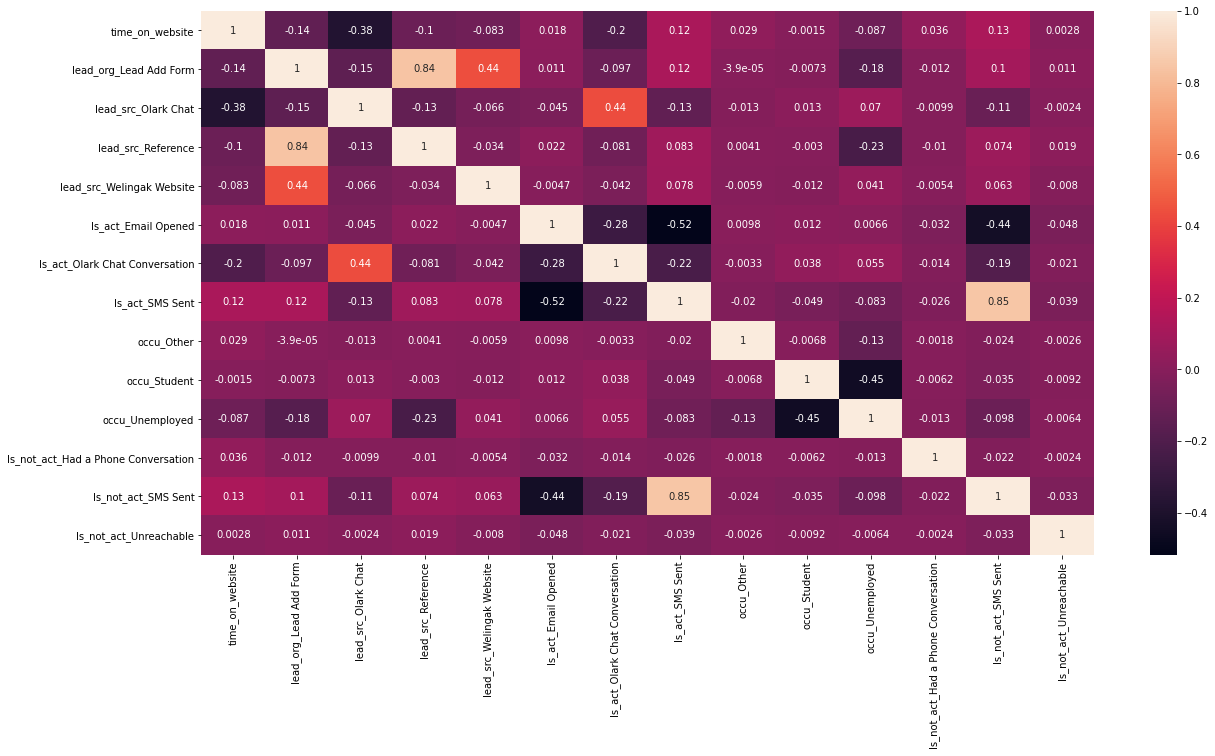

In [59]:
# Let's see the correlation matrix 

plt.figure(figsize = (20,10))        # Size of the figure
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

sns.heatmap(X_train[model_cols].corr(),annot = True)
plt.show()

In [60]:
# Getting the Predicted values on the train set
y_train_pred = model2.predict(sm.add_constant(X_train[model_cols]))
y_train_pred[:10]

9034    0.839477
1490    0.970911
2017    0.019806
8133    0.118945
4977    0.766186
3462    0.476775
4417    0.258770
5415    0.122410
1691    0.110006
4064    0.258770
dtype: float64

In [61]:
train_pred_table = pd.DataFrame()
train_pred_table['Actual'] = y_train
train_pred_table['Predict_Prob'] = y_train_pred
train_pred_table.head()

,Actual,Predict_Prob
9034,1,0.839477
1490,1,0.970911
2017,0,0.019806
8133,0,0.118945
4977,1,0.766186


In [62]:
train_pred_table['Predicted'] = train_pred_table.Predict_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
train_pred_table.head()

,Actual,Predict_Prob,Predicted
9034,1,0.839477,1
1490,1,0.970911,1
2017,0,0.019806,0
8133,0,0.118945,0
4977,1,0.766186,1


In [63]:
train_pred_table['Predicted'] = train_pred_table.Predict_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
train_pred_table.head()

,Actual,Predict_Prob,Predicted
9034,1,0.839477,1
1490,1,0.970911,1
2017,0,0.019806,0
8133,0,0.118945,0
4977,1,0.766186,1


In [64]:
# Confusion matrix 
confusion = metrics.confusion_matrix(train_pred_table.Actual, train_pred_table.Predicted)
print(confusion)

[[3379  419]
 [ 723 1641]]


In [65]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(train_pred_table.Actual, train_pred_table.Predicted))

0.8146705615060046


In [66]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [67]:
# Let's check the sensitivity of our logistic regression model
TP / float(TP+FN)

0.6941624365482234

- It indicates that 70.71% of true positives or here in our case converted values are predicted correctly by our model. It's a good start for this cutoff of 0.5.
- We'll see if we can improve our metrics.

In [68]:
# Let us calculate specificity
TN / float(TN+FP)

0.8896787783043707

In [69]:
# Calculate False Postive Rate - predicting conversion when customer does not have convert
print(FP/ float(TN+FP))

0.11032122169562927


In [70]:
# positive predictive value 
print (TP / float(TP+FP))

0.7966019417475728


In [71]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8237445148707947


### Plotting ROC Curve

- `ROC curve` shows the tradeoff between `True Positive Rate` & `False Positive Rate`.
- Theoretically we want `True Positive Rate` to be 1 & `False Positive Rate` to be 0.
- But in reality we can't get that kind of accuracy. However more the area ROC Curver covers, better the model is considered. On the other hand, the curve closer to 45 degree diagonal of the ROC space is considered less accurate.

In [72]:
# Function to plot ROC curve
def draw_roc(actual, probs):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    fig = px.area(
      x=fpr, y=tpr,
      title=f'ROC Curve (AUC={auc_score:.4f})',
      labels=dict(x='False Positive Rate', y='True Positive Rate'),
      width=600, height=550
    )
    fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
    )

    return fig

In [73]:
# Plot ROC Curve
draw_roc(train_pred_table.Actual, train_pred_table.Predict_Prob).show()

**Notable Obervations:**
- Curve is closer to left which shows that model has good accuracy.
- ROC Curve is covering 88% of total area.

### Choosing Right Cutoff

In [74]:
# Let's create columns with different cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    train_pred_table[i]= train_pred_table.Predict_Prob.map(lambda x: 1 if x > i else 0)
train_pred_table.head(10)

,Actual,Predict_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
9034,1,0.839477,1,1,1,1,1,1,1,1,1,1,0
1490,1,0.970911,1,1,1,1,1,1,1,1,1,1,1
2017,0,0.019806,0,1,0,0,0,0,0,0,0,0,0
8133,0,0.118945,0,1,1,0,0,0,0,0,0,0,0
4977,1,0.766186,1,1,1,1,1,1,1,1,1,0,0
3462,1,0.476775,0,1,1,1,1,1,0,0,0,0,0
4417,0,0.258770,0,1,1,1,0,0,0,0,0,0,0
5415,0,0.122410,0,1,1,0,0,0,0,0,0,0,0
1691,0,0.110006,0,1,1,0,0,0,0,0,0,0,0
4064,0,0.258770,0,1,1,1,0,0,0,0,0,0,0


In [75]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['cutoff','accuracy','sensitivity','specificity'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(train_pred_table.Actual, train_pred_table[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     cutoff  accuracy  sensitivity  specificity
0.0     0.0  0.383642     1.000000     0.000000
0.1     0.1  0.595586     0.968274     0.363612
0.2     0.2  0.743265     0.913706     0.637177
0.3     0.3  0.793574     0.830372     0.770669
0.4     0.4  0.813859     0.766497     0.843339
0.5     0.5  0.814671     0.694162     0.889679
0.6     0.6  0.797793     0.593063     0.925224
0.7     0.7  0.783999     0.517343     0.949974
0.8     0.8  0.752840     0.401861     0.971301
0.9     0.9  0.713242     0.271151     0.988415


- The objective to perform the above steps using confusion matrix is to find the most optimal cutoff value where the three metrics - `Accuracy`, `Sensitivity` and `Specificity` have almost similar values as these are of equal importance when it comes to model evaluation.
- Based on the above table, we can see that probability cutoff value of 0.35 is the most optimal here. 
- To further validate the optimal cutoff, let's plot the three metrics and visualise the convergence point.

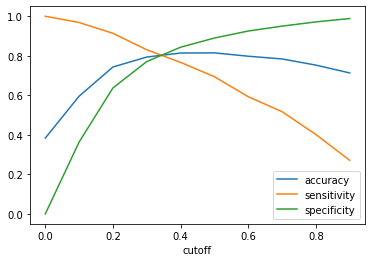

In [76]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='cutoff', y=['accuracy','sensitivity','specificity'])
plt.show()

In [77]:
#### From the curve above, ~0.35 seems the optimum point to take it as a cutoff probability.
cutoff = 0.35

# Updating Predicted column with new cutoff
train_pred_table['Predicted'] = train_pred_table.Predict_Prob.map( lambda x: 1 if x > cutoff else 0)

train_pred_table.head(10)

,Actual,Predict_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
9034,1,0.839477,1,1,1,1,1,1,1,1,1,1,0
1490,1,0.970911,1,1,1,1,1,1,1,1,1,1,1
2017,0,0.019806,0,1,0,0,0,0,0,0,0,0,0
8133,0,0.118945,0,1,1,0,0,0,0,0,0,0,0
4977,1,0.766186,1,1,1,1,1,1,1,1,1,0,0
3462,1,0.476775,1,1,1,1,1,1,0,0,0,0,0
4417,0,0.258770,0,1,1,1,0,0,0,0,0,0,0
5415,0,0.122410,0,1,1,0,0,0,0,0,0,0,0
1691,0,0.110006,0,1,1,0,0,0,0,0,0,0,0
4064,0,0.258770,0,1,1,1,0,0,0,0,0,0,0


In [78]:
# Let's check the overall accuracy.
accuracy_tr = metrics.accuracy_score(train_pred_table.Actual, train_pred_table.Predicted)
accuracy_tr

0.8076923076923077

In [79]:
confusion2 = metrics.confusion_matrix(train_pred_table.Actual, train_pred_table.Predicted )
confusion2

array([[3088,  710],
       [ 475, 1889]])

In [80]:
TP = confusion2[1,1] # true positive
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

### Sensitivity-Specificity

In [81]:
# Let's see the sensitivity of our logistic regression model
sensitivity = (TP / float(TP+FN))
# Let us calculate specificity
specificity = TN / float(TN+FP)

### Precision-Recall

In [82]:
# calculate Precision & Recall
precision = (TP/float(FP+TP))
recall = (TP/float(FN+TP))


# we can also use inbuilt library
# from sklearn.metrics import precision_score, recall_score
# print('Precision', precision_score(train_pred_table.Actual , train_pred_table.Predicted))
# print('Recall:', recall_score(train_pred_table.Actual, train_pred_table.Predicted))

In [83]:
print('Accuracy: ', accuracy_tr*100,'\n______________________________')
print('Sensitivity: ', sensitivity*100)
print('Specificity: ', specificity*100)
print('Precision: ', precision*100)
print('Recall: ', recall*100)

Accuracy:  80.76923076923077 
______________________________
Sensitivity:  79.90693739424704
Specificity:  81.3059505002633
Precision:  72.68180069257407
Recall:  79.90693739424704


- As observed, a `Precision` score of 73% reflects the high relevancy of model results and `Recall` score of 79% reflects true relevant scores. Hence, the model is highly accurate and relevant.
- As per the business requirement, preference would be given to `Recall percentage` as the business wouldn't want to leave out hot leads which have high chance of converting. 

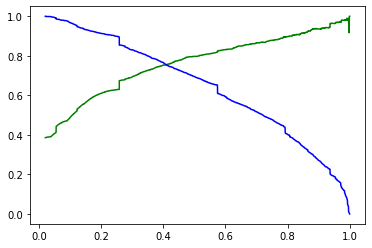

In [84]:
# Plotting Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(train_pred_table.Actual, train_pred_table.Predict_Prob)
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "b-")
plt.show()

## Model Prediction

In [85]:
# Scaling Numeric Features of test dataset
X_test[num_cols] = scaler.transform(X_test[num_cols])
X_test = X_test[model_cols]
X_test.head()

,time_on_website,lead_org_Lead Add Form,lead_src_Olark Chat,lead_src_Reference,lead_src_Welingak Website,ls_act_Email Opened,ls_act_Olark Chat Conversation,ls_act_SMS Sent,occu_Other,occu_Student,occu_Unemployed,ls_not_act_Had a Phone Conversation,ls_not_act_SMS Sent,ls_not_act_Unreachable
7895,1.150502,0,0,0,0,0,0,0,0,0,1,0,0,0
9032,1.582115,0,0,0,0,0,0,1,0,0,1,0,0,0
4120,-0.495482,0,0,0,0,1,0,0,0,0,1,0,0,0
5983,0.907262,0,0,0,0,1,0,0,0,0,1,0,0,0
6381,-0.144339,0,0,0,0,0,0,1,0,0,1,0,1,0


In [86]:
# Predicting Y Probability on test dataset
y_test_pred = model2.predict(sm.add_constant(X_test[model_cols]))
y_test_pred[:10]

7895    0.278903
9032    0.630977
4120    0.133095
5983    0.423548
6381    0.467618
291     0.020126
307     0.020947
7781    0.045114
3465    0.936282
238     0.112472
dtype: float64

In [87]:
test_pred_table = pd.DataFrame()
test_pred_table['Actual'] = y_test
test_pred_table['Predict_Prob'] = y_test_pred
test_pred_table['Predicted'] = test_pred_table['Predict_Prob'].map(lambda x: 1 if x > cutoff else 0)
test_pred_table.head()

,Actual,Predict_Prob,Predicted
7895,1,0.278903,0
9032,1,0.630977,1
4120,0,0.133095,0
5983,1,0.423548,1
6381,1,0.467618,1


In [88]:
accuracy_val = metrics.accuracy_score(test_pred_table['Actual'], test_pred_table['Predicted'])
accuracy_val

0.805450416351249

In [89]:
confusion3 = metrics.confusion_matrix(test_pred_table['Actual'], test_pred_table['Predicted'])
confusion3

array([[1318,  311],
       [ 203,  810]])

In [90]:
TP_v = confusion3[1,1] # true positive 
TN_v = confusion3[0,0] # true negatives
FP_v = confusion3[0,1] # false positives
FN_v = confusion3[1,0] # false negatives

### Sensitivity-Specificity

In [91]:
# Calculating Sensitivity & Specificity in test dataset
sensitivity_v = (TP_v / float(TP_v+FN_v))
specificity_v = TN_v / float(TN_v+FP_v)

In [92]:
# Comparing sensitivity/specificity of our logistic regression model in train & test dataset
print('Sensitivity in test dataset is: ', sensitivity_v)
print('Specificity in test dataset is: ', specificity_v)
print('Accuracy in test dataset is: ', accuracy_val)
print('___________________________________________________')
print('Sensitivity in train dataset is: ', sensitivity)
print('Specificity in train dataset is: ', specificity)
print('Accuracy in train dataset is: ', accuracy_tr)

Sensitivity in test dataset is:  0.7996051332675223
Specificity in test dataset is:  0.809085328422345
Accuracy in test dataset is:  0.805450416351249
___________________________________________________
Sensitivity in train dataset is:  0.7990693739424704
Specificity in train dataset is:  0.8130595050026329
Accuracy in train dataset is:  0.8076923076923077


### Precision-Recall

In [93]:
# calculate Precision & Recall
precision_v = (TP_v/float(FP_v+TP_v))
recall_v = (TP_v/float(TP_v+FN_v))

In [94]:
print('Precision score is:', precision_v)
print('Recall score is:', recall_v)

Precision score is: 0.7225691347011597
Recall score is: 0.7996051332675223


## Assigning Lead Score

In [95]:
# Assigning Lead_score to table

test_pred_table['Lead Score'] = test_pred_table['Predict_Prob'].apply(lambda x:round(x*100))
test_pred_table.head()

,Actual,Predict_Prob,Predicted,Lead Score
7895,1,0.278903,0,28
9032,1,0.630977,1,63
4120,0,0.133095,0,13
5983,1,0.423548,1,42
6381,1,0.467618,1,47


## Model Insight



In [96]:
#Selecting the coefficients of the selected features from our final model excluding the intercept
pd.options.display.float_format = '{:.2f}'.format
params_eval = model2.params[1:]
params_eval

time_on_website                        1.12
lead_org_Lead Add Form                 2.81
lead_src_Olark Chat                    1.25
lead_src_Reference                     0.83
lead_src_Welingak Website              3.00
ls_act_Email Opened                    0.91
ls_act_Olark Chat Conversation        -0.87
ls_act_SMS Sent                        1.00
occu_Other                            -2.11
occu_Student                          -2.42
occu_Unemployed                       -2.72
ls_not_act_Had a Phone Conversation    3.75
ls_not_act_SMS Sent                    1.26
ls_not_act_Unreachable                 2.31
dtype: float64

In [97]:
#Getting a relative coeffient value for all the features wrt the feature with the highest coefficient
feature_importance = params_eval
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_importance

time_on_website                        29.75
lead_org_Lead Add Form                 74.80
lead_src_Olark Chat                    33.32
lead_src_Reference                     22.16
lead_src_Welingak Website              79.87
ls_act_Email Opened                    24.34
ls_act_Olark Chat Conversation        -23.13
ls_act_SMS Sent                        26.78
occu_Other                            -56.30
occu_Student                          -64.52
occu_Unemployed                       -72.55
ls_not_act_Had a Phone Conversation   100.00
ls_not_act_SMS Sent                    33.61
ls_not_act_Unreachable                 61.68
dtype: float64

In [98]:
# Sorting the features based on their coefficient values
sorted_imp = np.argsort(feature_importance,kind='quicksort',order='list of str')
sorted_imp

time_on_website                        10
lead_org_Lead Add Form                  9
lead_src_Olark Chat                     8
lead_src_Reference                      6
lead_src_Welingak Website               3
ls_act_Email Opened                     5
ls_act_Olark Chat Conversation          7
ls_act_SMS Sent                         0
occu_Other                              2
occu_Student                           12
occu_Unemployed                        13
ls_not_act_Had a Phone Conversation     1
ls_not_act_SMS Sent                     4
ls_not_act_Unreachable                 11
dtype: int64

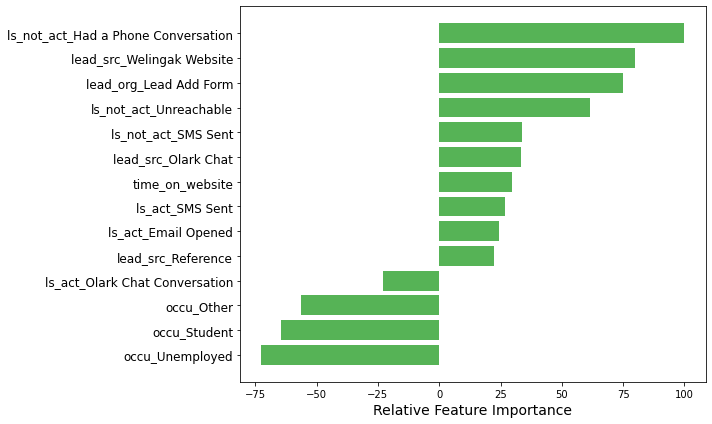

In [99]:
# Plot showing the inportance of features based on their relative coefficient values

pos = np.arange(sorted_imp.shape[0]) + .5
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
ax.barh(pos, feature_importance[sorted_imp], align='center', color = 'tab:green',alpha=0.8)
ax.set_yticks(pos)
ax.set_yticklabels(np.array(X_train[model_cols].columns)[sorted_imp], fontsize=12)
ax.set_xlabel('Relative Feature Importance', fontsize=14)

plt.tight_layout()   
plt.show()